In [ ]:
from astropy.io import fits

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt

# Going through the tutorial here: https://prospect.readthedocs.io/en/latest/quickstart.html

In [1]:
import fsps
import dynesty
import sedpy
import h5py, astropy
import numpy as np

ModuleNotFoundError: No module named 'fsps'

In [2]:
from astroquery.sdss import SDSS
from astropy.coordinates import SkyCoord
bands = "ugriz"
mcol = [f"cModelMag_{b}" for b in bands]
ecol = [f"cModelMagErr_{b}" for b in bands]
cat = SDSS.query_crossid(SkyCoord(ra=204.46376, dec=35.79883, unit="deg"), 
                         data_release=16, photoobj_fields=mcol + ecol + ["specObjID"])
shdus = SDSS.get_spectra(plate=2101, mjd=53858, fiberID=220)[0]
assert int(shdus[2].data["SpecObjID"][0]) == cat[0]["specObjID"]

ModuleNotFoundError: No module named 'astroquery'

In [ ]:
from sedpy.observate import load_filters
from prospect.utils.obsutils import fix_obs

filters = load_filters([f"sdss_{b}0" for b in bands])
maggies = np.array([10**(-0.4 * cat[0][f"cModelMag_{b}"]) for b in bands])
magerr = np.array([cat[0][f"cModelMagErr_{b}"] for b in bands])
magerr = np.clip(magerr, 0.05, np.inf)

obs = dict(wavelength=None, spectrum=None, unc=None, redshift=shdus[2].data[0]["z"],
           maggies=maggies, maggies_unc=magerr * maggies / 1.086, filters=filters)
obs = fix_obs(obs)

In [ ]:
from prospect.models.templates import TemplateLibrary
from prospect.models import SpecModel
model_params = TemplateLibrary["parametric_sfh"]
model_params.update(TemplateLibrary["nebular"])
model_params["zred"]["init"] = obs["redshift"]

model = SpecModel(model_params)
assert len(model.free_params) == 5
print(model)

In [ ]:
noise_model = (None, None)

In [ ]:
from prospect.sources import CSPSpecBasis
sps = CSPSpecBasis(zcontinuous=1)
print(sps.ssp.libraries)

In [ ]:
current_parameters = ",".join([f"{p}={v}" for p, v in zip(model.free_params, model.theta)])
print(current_parameters)
spec, phot, mfrac = model.predict(model.theta, obs=obs, sps=sps)
print(phot / obs["maggies"])

In [ ]:
from prospect.fitting import lnprobfn, fit_model
fitting_kwargs = dict(nlive_init=400, nested_method="rwalk", nested_posterior_thresh=0.05)
output = fit_model(obs, model, sps, optimize=False, dynesty=True, lnprobfn=lnprobfn, noise=noise_model, **fitting_kwargs)
result, duration = output["sampling"]

In [ ]:
from prospect.io import write_results as writer
hfile = "quickstart_dynesty_mcmc.h5"
writer.write_hdf5(hfile, {}, model, obs,
                 output["sampling"][0], None,
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=0.0)


In [1]:
import prospect.io.read_results as reader
res, obs, model = reader.results_from("global/cscratch1/sd/eramey16/data/lensed/Huang21_A/9906602215998531.h5")
res

ModuleNotFoundError: No module named 'prospect'

# Using Taskfarmer

In [1]:
import pandas as pd
import csv

In [7]:
galaxies = pd.read_csv("../data/first_query.txt", nrows=1000)

In [8]:
shft_cmd = "shifter --image=audreykoz/gradient:latest" \
" --volume='/global/cscratch1/sd/eramey16/data/testrun:/gradient_boosted/exports'" \
" /opt/conda/bin/python /gradient_boosted/classify.py -r {} -d {}"

In [9]:
galaxies['run'] = [shft_cmd.format(a,b) for a,b in zip(galaxies.ra, galaxies.dec)]

In [10]:
galaxies

,ls_id,ra,dec,run
0,8796115184194014,149.285304,1.345116,shifter --image=audreykoz/gradient:latest --vo...
1,8796115184193402,149.273901,1.313647,shifter --image=audreykoz/gradient:latest --vo...
2,8796115184193181,149.291823,1.303267,shifter --image=audreykoz/gradient:latest --vo...
3,8796115278499067,149.127949,1.530269,shifter --image=audreykoz/gradient:latest --vo...
4,8796115278498990,149.121014,1.526591,shifter --image=audreykoz/gradient:latest --vo...
...,...,...,...,...
995,8796115278693161,149.765329,1.415705,shifter --image=audreykoz/gradient:latest --vo...
996,8796115278693010,149.784284,1.406019,shifter --image=audreykoz/gradient:latest --vo...
997,8796115278693406,149.765189,1.427825,shifter --image=audreykoz/gradient:latest --vo...
998,8796115278693488,149.783395,1.435049,shifter --image=audreykoz/gradient:latest --vo...


In [11]:
galaxies['run'].to_csv('../data/tasks.txt', sep='\t', header=False, index=False, quoting=3)

In [38]:
galaxies = pd.read_csv("../data/masterlens.tsv", skiprows=1, sep='\t')

In [41]:
galaxies.columns = galaxies.columns.str.replace('"', '')
galaxies.columns = galaxies.columns.str.strip()
# galaxies.apply(lambda s: s.str.replace('"', ""))
# galaxies.apply(lambda s: s.str.strip())
galaxies.columns

Index(['# system_name', 'discovery_date', 'alternate_name', 'kind_acronym',
       'discovery_acronym', 'reference_identifier', 'ra_hrs', 'ra_mins',
       'ra_secs', 'ra_coord', 'dec_degrees', 'dec_arcmin', 'dec_arcsec',
       'dec_coord', 'lensgrade', 'number_images', 'theta_e', 'theta_e_err',
       'theta_e_quality', 'z_lens', 'z_lens_err', 'z_lens_quality', 'z_source',
       'z_source_err', 'z_source_quality', 'vdisp', 'vdisp_err', 'filter_lens',
       'filter_source', 'fluxes', 'mag_lens', 'mag_source', 'morphology',
       'has_sdss', 'sdss_link', 'has_adsabs', 'adsabs_link', 'apod_link',
       'vett_status', 'released_status', 'hidden_status', 'vetted', 'released',
       'hidden', 'graphic_status', 'equinox', 'sdss_ObjID', 'sdss_specObjID',
       'time_delay0', 'time_delay1', 'lens_name'],
      dtype='object')

In [48]:
radec = galaxies[['ra_coord', 'dec_coord']]
radec.columns = ['ra', 'dec']
radec.to_csv('coords_A.csv', index=False)

In [33]:
galaxies.iloc[0]['discovery_date']

' "2008-08-01"'

In [23]:
galaxies = pd.read_csv('../data/lensed/Huang21_C/Huang21_C.csv')
galaxies.columns = [x.lower() for x in galaxies.columns]

In [24]:
radec = galaxies[['ra', 'dec']]

In [25]:
with open("../data/lensed/all_lensed/galaxies.csv", 'a') as file:
    radec.to_csv(file, index=False, header=False)

# Aggregate outputs

In [1]:
import glob
import pandas as pd
import numpy as np

In [2]:
filenames = glob.glob('../data/testrun/[0-9]*.csv')

In [3]:
data = []
for file in filenames:
    data.append(pd.read_csv(file))

data = pd.concat(data, ignore_index = True)

In [4]:
data

,ls_id,lensed
0,8796115184321665,1
1,8796115089953404,0
2,8796115089888045,1
3,8796115089887865,0
4,8796115278562997,0
...,...,...
968,8796115184323951,0
969,8796115184324356,1
970,8796115278564472,0
971,8796115089888210,0


In [5]:
np.sum(data['lensed'])

568

In [6]:
data.to_csv('../data/testrun/total_lensed.csv', index=False)

In [1]:
from util import collect_lensed, collect_gals

In [2]:
data = collect_lensed('../data/testrun')

Total lensed: 568 / 973


In [4]:
data = collect_lensed('../data/lensed/ML_A')

Total lensed: 78 / 199


In [5]:
data = collect_lensed('../data/lensed/ML_B')

Total lensed: 26 / 56


In [6]:
data = collect_lensed('../data/lensed/ML_C')

Total lensed: 34 / 62


In [7]:
data = collect_lensed('../data/lensed/Huang21_A')

Total lensed: 106 / 206


In [8]:
data = collect_lensed('../data/lensed/Huang21_B')

Total lensed: 117 / 191


In [9]:
data = collect_lensed('../data/lensed/Huang21_C')

Total lensed: 572 / 843


In [2]:
data = collect_gals('../data/testrun')

In [5]:
data

,ls_id,ra,dec,type,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,unc_g,...,unc_w2,z_phot_median,z_phot_std,z_spec,dered_flux_g,dered_flux_r,dered_flux_z,dered_flux_w1,dered_flux_w2,tag
0,8796115089951731,149.841244,1.018637,DEV,23.201754,22.356958,22.289858,23.750008,NaN,0.065150,...,-0.690722,0.432835,0.178050,-99.0000,0.523961,1.140819,1.213548,0.316226,-2.148673,tst
1,8796115278562038,149.421547,1.406107,DEV,21.702497,21.372538,21.452879,NaN,NaN,0.045546,...,-0.140871,0.231661,0.239397,-99.0000,2.084496,2.824783,2.623304,-1.900767,-15.072433,tst
2,8796115184194653,149.375348,1.374884,DEV,24.719746,23.504185,21.305895,19.629570,20.209246,0.249244,...,0.177981,0.999594,0.104023,-99.0000,0.129450,0.396575,3.003602,14.066046,8.247109,tst
3,8796115278562014,149.376562,1.402851,DEV,25.426490,23.366247,21.207819,19.580494,20.832440,0.670884,...,0.327308,0.956415,0.093704,-99.0000,0.067516,0.450299,3.287548,14.716435,4.645409,tst
4,8796115278498251,149.219260,1.492591,DEV,22.977180,23.026808,22.552841,22.025452,20.894102,0.048105,...,0.325019,1.210540,0.341453,-99.0000,0.644359,0.615569,0.952497,1.548173,4.388934,tst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,8796115184258833,149.580977,1.301445,DEV,24.912098,23.390469,21.305450,19.205685,19.941689,0.237642,...,0.133211,0.972528,0.108875,-99.0000,0.108433,0.440364,3.004832,20.783869,10.551753,tst
1090,8796115184255958,149.635783,1.165474,DEV,24.445368,22.180323,20.618673,19.200708,20.230045,0.245999,...,0.183343,0.708734,0.040529,-99.0000,0.166668,1.342366,5.656280,20.879320,8.090620,tst
1091,8796115278564395,149.492409,1.509756,DEV,23.117222,21.776560,20.934420,19.321192,19.791760,0.104514,...,0.131365,0.594347,0.080693,0.6576,0.566384,1.947045,4.228945,18.686295,12.114234,tst
1092,8796115089952319,149.813087,1.044961,DEV,19.671507,19.266603,19.040766,19.442953,20.152079,0.004291,...,0.175434,0.088458,0.035541,-99.0000,13.533103,19.649826,24.193240,16.703941,8.692971,tst


# Random data processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util import collect_gals
seed = 42

import matplotlib as mpl
import matplotlib.transforms as transforms
plt.rcParams.update({'font.size': 20})

import seaborn as sns

In [2]:
use_cols = ['dered_mag_g', 'dered_mag_r', 'dered_mag_z', 'dered_mag_w1', 'dered_mag_w2', 
            'z_phot_median', 'min_dchisq']
dchisq_labels = [f'dchisq_{i}' for i in range(1,6)]
rchisq_labels = ['rchisq_g', 'rchisq_r', 'rchisq_z', 'rchisq_w1', 'rchisq_w2']

In [3]:
def filter_data(data):
    # Remove bad / duplicate entries
    data = data[data.type!='DUP']
    data = data[data.type!='PSF']
    data = data[data.dered_mag_r<=22]
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data = data.dropna()
    data.drop_duplicates(subset=['ls_id'], inplace=True)
    
    # Colors
    data['g-r'] = data['dered_mag_g']-data['dered_mag_r']
    data['r-z'] = data['dered_mag_r']-data['dered_mag_z']
    data['r-w1'] = data['dered_mag_r']-data['dered_mag_w1']
    data['r-w2'] = data['dered_mag_r']-data['dered_mag_w2']
    
    # Calculate minimum dchisq
    dchisq = np.array(data[dchisq_labels])
    data['min_dchisq'] = np.min(dchisq, axis=1)
    
    # Calculate sum rchisq
    rchisq = np.array(data[rchisq_labels])
    data['sum_rchisq'] = np.sum(rchisq, axis=1)
    
    # Calculate abs mag in r band
    dm = 5*np.log10(300000*data.z_phot_median/70)+25
    data['abs_mag_r'] = data.dered_mag_r - dm
    
    return data

In [4]:
one_gal = collect_gals('../data/special_run')
one_gal = filter_data(one_gal)
one_gal.to_csv('../data/special_run/galaxy_info.csv', index=False)

### Lensed data

In [4]:
# Collect data from lensed galaxy run
data2 = collect_gals("../data/lensed/all_lensed")
data2['lensed'] = True

data2 = filter_data(data2)
data2

,ls_id,ra,dec,type,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,snr_g,...,shape_r,shape_r_ivar,lensed,g-r,r-z,r-w1,r-w2,min_dchisq,sum_rchisq,abs_mag_r
1,9906609639789008,47.143402,-32.991921,REX,20.659416,19.732227,19.240520,19.286774,18.481714,0.007928,...,0.000000,0.000,True,0.927189,0.491707,0.445453,1.250513,0.000,6.057908,-21.244197
2,9907736363600008,190.134534,45.150801,SER,19.561155,18.195772,17.451612,17.319870,17.745071,0.009489,...,0.154641,51592.598,True,1.365383,0.744160,0.875902,0.450701,76830.055,5.310131,-21.930535
4,9906619942636239,133.034804,-4.091204,SER,21.537740,19.787130,18.790407,18.320759,18.752010,0.025231,...,0.088281,5711.582,True,1.750610,0.996723,1.466371,1.035120,21131.190,5.085282,-21.523569
5,9906621833741640,148.832186,1.029002,SER,18.581133,17.474730,16.684725,16.717117,17.115856,0.003160,...,-0.199910,438420.340,True,1.106403,0.790005,0.757613,0.358874,723000.400,26.451703,-21.526164
6,9906612536743832,36.832586,-24.192152,DEV,21.136698,19.290007,18.374294,17.622557,18.142902,0.010217,...,-0.078974,73437.350,True,1.846691,0.915713,1.667450,1.147105,173344.660,10.001980,-21.981708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,9906609630094268,3.264640,-32.964802,SER,20.879540,19.278364,18.324753,17.956623,18.574476,0.009090,...,0.071677,98519.890,True,1.601176,0.953611,1.321741,0.703888,135820.800,8.699469,-21.617455
1102,9906622306063576,150.725312,2.241703,SER,20.874355,19.068508,17.968708,17.274813,17.819244,0.018111,...,-0.192758,28128.630,True,1.805847,1.099800,1.793695,1.249264,52570.953,10.488627,-22.552444
1103,9906609956067761,36.084287,-31.937040,SER,21.379213,19.535542,18.390648,17.578798,18.323383,0.028951,...,0.051197,11829.180,True,1.843671,1.144894,1.956744,1.212159,20084.477,4.455446,-22.196688
1104,9906611268617408,53.159315,-27.948129,SER,21.819874,20.142654,18.721580,17.798424,18.594970,0.021394,...,0.247839,28283.648,True,1.677220,1.421074,2.344230,1.547684,68177.670,6.929768,-22.075022


In [5]:
data2.to_csv("../data/dr9_training/dr9_lensed.csv", index=False)

In [6]:
# lensed = data2[use_cols]
# lensed.to_csv("../data/lensed.dat", index=False)

(19.06381688084112, 1.4524781577238661)

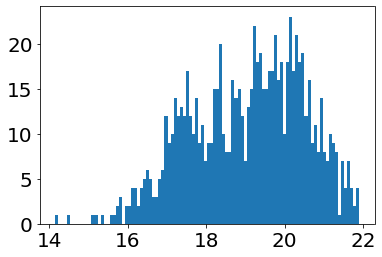

In [7]:
_ = plt.hist(data2['dered_mag_r'], bins=100)
mu, sigma = np.mean(data2['dered_mag_r']), np.std(data2['dered_mag_r'])
mu, sigma

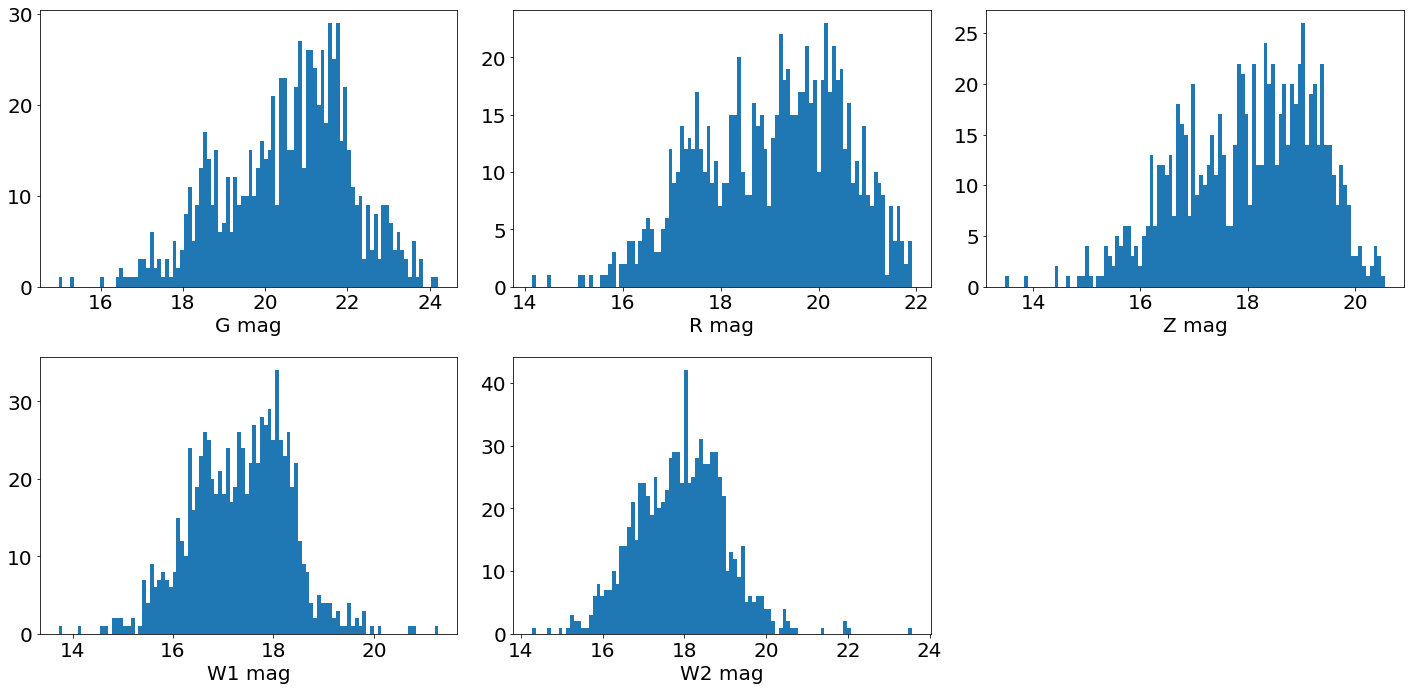

In [8]:
data = data2

fig, axes = plt.subplots(2, 3, figsize=(20,10))

axes[0,0].hist(data['dered_mag_g'], bins=100)
axes[0,0].set_xlabel('G mag')

axes[0,1].hist(data['dered_mag_r'], bins=100)
axes[0,1].set_xlabel('R mag')

axes[0,2].hist(data['dered_mag_z'], bins=100)
axes[0,2].set_xlabel('Z mag')

axes[1,0].hist(data['dered_mag_w1'], bins=100)
axes[1,0].set_xlabel('W1 mag')

axes[1,1].hist(data['dered_mag_w2'], bins=100)
axes[1,1].set_xlabel('W2 mag')

axes[1,2].axis('off')
plt.tight_layout()
plt.savefig('lensed_magnitudes.png', bbox_inches='tight')

### Unlensed

In [9]:
# Read full DR9 set
data1 = pd.read_csv('../data/dr9_training/dr9_7deg.csv')
# Input lensing
data1['lensed'] = False

data1 = filter_data(data1)
data1

,ls_id,ra,dec,type,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,snr_g,...,shape_r,shape_r_ivar,lensed,g-r,r-z,r-w1,r-w2,min_dchisq,sum_rchisq,abs_mag_r
5,9906620228632967,145.470866,-3.315739,REX,20.088380,19.271555,18.755926,18.852388,18.983309,132.267880,...,1.471188,46842.5040,False,0.816825,0.515629,0.419167,0.288246,0.0000,4.763794,-21.206272
12,9906620228633087,145.477949,-3.343601,REX,21.368332,20.619652,20.109747,20.222530,20.688862,76.675606,...,0.266593,26254.8900,False,0.748680,0.509905,0.397122,-0.069210,0.0000,4.230055,-19.848317
31,9906620228572307,145.448558,-3.318298,REX,21.826778,20.490038,19.627012,18.971241,19.496113,47.337490,...,0.598901,25299.0370,False,1.336740,0.863026,1.518797,0.993925,0.0000,5.085612,-21.072127
50,9906620322810585,145.144207,-3.035941,SER,20.557575,19.432552,18.755602,18.665533,19.084768,87.023520,...,1.424555,8313.2690,False,1.125023,0.676950,0.767019,0.347784,38478.2970,9.038768,-20.649842
51,9906620322810670,145.150162,-3.049282,EXP,22.388834,20.953814,20.214180,19.874810,20.569073,21.217490,...,1.060481,2382.8190,False,1.435020,0.739634,1.079004,0.384741,3716.2360,4.508512,-20.459355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499977,9906620700823316,147.206358,-2.094354,EXP,22.906744,21.921455,21.538954,20.960077,22.970842,16.159640,...,0.406523,995.1159,False,0.985289,0.382501,0.961378,-1.049387,1263.5009,3.840958,-19.848242
499979,9906620700823446,147.214311,-2.101177,EXP,22.558243,21.042349,20.281431,21.470135,21.567415,19.835726,...,0.520897,4243.6600,False,1.515894,0.760918,-0.427786,-0.525066,4482.0040,9.239083,-19.720977
499986,9906620700823762,147.232143,-2.097847,EXP,20.925486,20.612787,20.371380,21.287240,20.627476,62.010390,...,1.312715,2587.7434,False,0.312699,0.241407,-0.674453,-0.014689,5549.5083,4.174620,-17.511929
499994,9906620700823543,147.220042,-2.084160,EXP,22.398489,21.465921,20.897678,20.765343,22.357271,21.632015,...,0.898340,883.0505,False,0.932568,0.568243,0.700578,-0.891350,1784.8842,4.254630,-19.873689


In [10]:
data1.to_csv("../data/dr9_training/dr9_cosmos_test.csv", index=False)

In [10]:
# data1 = data1.sample(n=10000)
# data1.to_csv("../data/dr9_training/dr9_unlensed.csv", index=False)

In [11]:
# Get a gaussian sample around the r-magnitudes of lensed galaxies
# weights = np.exp(-.5*((data1['dered_mag_r']-mu)/sigma)**2) # normal distribution
# data1 = data1.sample(n=10000, weights=weights, random_state=seed)

In [12]:
# nonlensed = data1[use_cols]
# nonlensed.to_csv("../data/nonlensed.dat", index=False)

### Ampel run

In [13]:
data3 = collect_gals("../data/ampel_run")
data3 = filter_data(data3)
data3

,ls_id,ra,dec,type,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,snr_g,...,shape_e2_ivar,shape_r,shape_r_ivar,g-r,r-z,r-w1,r-w2,min_dchisq,sum_rchisq,abs_mag_r
0,9906626190446675,339.504678,12.590152,SER,17.274237,16.327522,15.667729,15.858350,16.365630,0.002002,...,700729.940,0.034764,998456.560,0.946715,0.659793,0.469172,-0.038108,639848.940,14.180929,-21.976832
1,9906628295266353,24.446324,18.377803,SER,18.438350,17.664242,17.085630,16.392185,16.196589,0.001971,...,350040.720,0.091164,554638.200,0.774108,0.578612,1.272057,1.467653,1041440.000,21.285649,-21.900404
2,9907732793330661,279.468548,32.884967,REX,20.619589,19.768860,19.233198,19.248898,19.860447,0.009714,...,0.000,0.000000,0.000,0.850729,0.535662,0.519962,-0.091587,0.000,4.206965,-19.932285
3,9906620618904648,194.687165,-2.287789,SER,18.974031,18.300507,17.691603,16.728569,16.642950,0.002433,...,66314.690,0.088478,85134.984,0.673524,0.608904,1.571938,1.657557,415156.160,21.046489,-21.852442
4,9907736021568351,162.932965,44.122499,REX,20.470890,20.285822,20.214720,20.296675,20.797098,0.009371,...,0.000,0.000000,0.000,0.185068,0.071102,-0.010853,-0.511276,0.000,11.416365,-17.088526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,9906630448451981,199.184602,24.449461,SER,20.637745,20.127794,19.799294,20.402958,21.225140,0.007691,...,13637.611,-0.342248,14584.580,0.509951,0.328500,-0.275164,-1.097346,28795.746,4.309353,-19.053112
862,9906628745692582,38.513121,19.778986,SER,20.615206,20.119373,19.788725,20.356400,20.884573,0.012112,...,52010.130,-0.171301,51851.184,0.495833,0.330648,-0.237027,-0.765200,9222.450,4.919896,-18.898732
864,9906618304630170,332.107606,-8.524351,EXP,20.576668,20.255249,20.069975,20.331870,21.617674,0.007245,...,14957.955,-0.205817,18269.914,0.321419,0.185274,-0.076621,-1.362425,30448.709,4.618526,-18.175192
866,9906619995653644,335.547332,-4.006682,SER,17.087030,16.223003,15.647518,15.981176,16.495977,0.001417,...,1659860.200,0.157347,2303901.000,0.864027,0.575485,0.241827,-0.272974,868269.750,10.305778,-21.489194


In [14]:
data3.to_csv("../data/dr9_training/ampel_test.csv", index=False)

In [15]:
len(data3)

493

(0.01, 5)

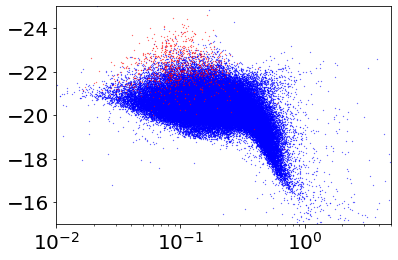

In [14]:
# Absolute magnitude
plt.plot(data1.dered_flux_g/data1.dered_flux_z, data1['abs_mag_r'], 'b.', ms=.5)

plt.plot(data2.dered_flux_g/data2.dered_flux_z, data2['abs_mag_r'], 'r.', ms=.5)
plt.xscale('log')
plt.ylim([-15, -25])
plt.xlim([1e-2, 5])

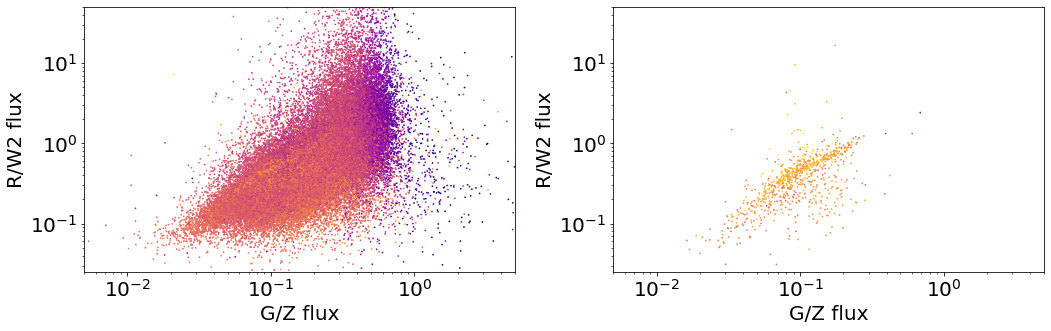

In [15]:
# Magnitude comparison
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].scatter(data1.dered_flux_g/data1.dered_flux_z, 
                data1.dered_flux_r/data1.dered_flux_w2, 
                cmap='plasma_r', s=.5, c=data1['abs_mag_r'], vmax=-16, vmin=-24)
axes[0].set_xlabel("G/Z flux")
axes[0].set_ylabel("R/W2 flux")
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim([.5e-2, 5])
axes[0].set_ylim([.25e-1, 50])

axes[1].scatter(data2.dered_flux_g/data2.dered_flux_z,
                data2.dered_flux_r/data2.dered_flux_w2, 
                cmap='plasma_r', s=.5, c=data2['abs_mag_r'], vmin=-24, vmax=-16)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim([.5e-2, 5])
axes[1].set_ylim([.25e-1, 50])
axes[1].set_xlabel("G/Z flux")
axes[1].set_ylabel("R/W2 flux")

plt.tight_layout()

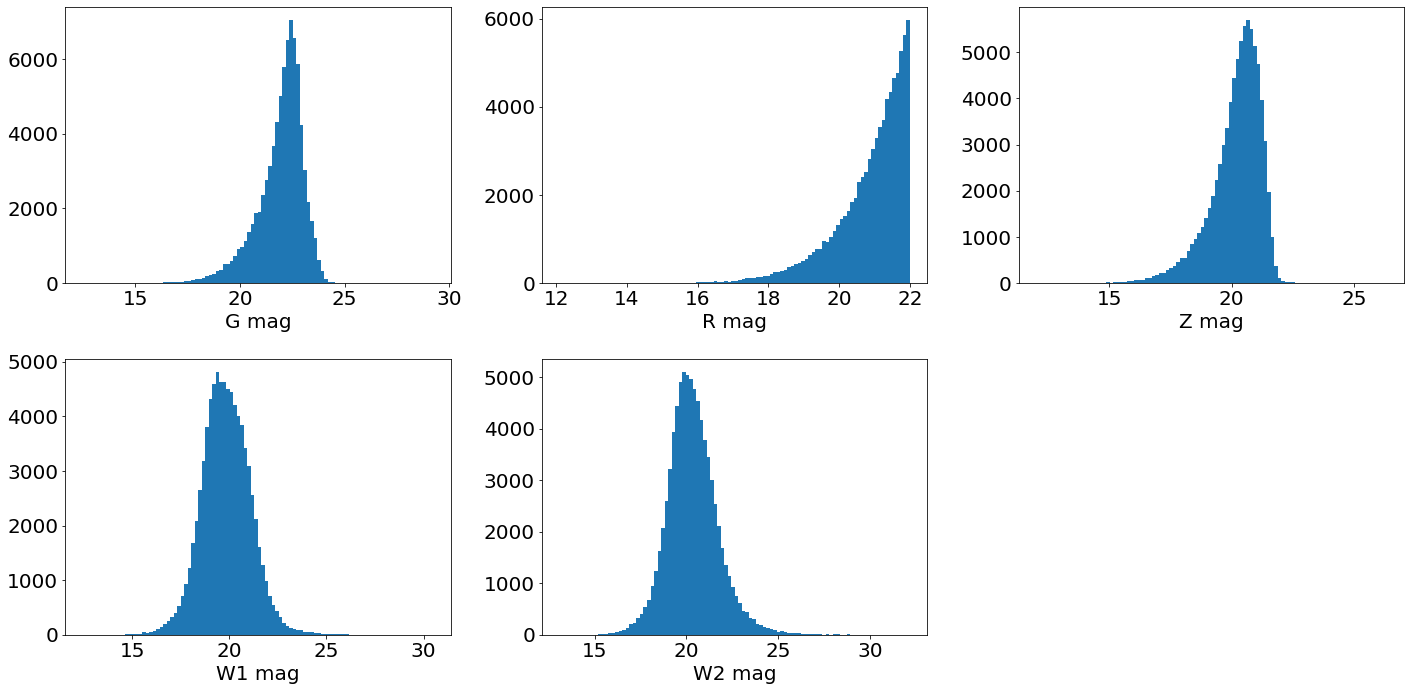

In [16]:
data = data1
fig, axes = plt.subplots(2, 3, figsize=(20,10))

axes[0,0].hist(data['dered_mag_g'], bins=100)
axes[0,0].set_xlabel('G mag')

axes[0,1].hist(data['dered_mag_r'], bins=100)
axes[0,1].set_xlabel('R mag')

axes[0,2].hist(data['dered_mag_z'], bins=100)
axes[0,2].set_xlabel('Z mag')

axes[1,0].hist(data['dered_mag_w1'], bins=100)
axes[1,0].set_xlabel('W1 mag')

axes[1,1].hist(data['dered_mag_w2'], bins=100)
axes[1,1].set_xlabel('W2 mag')

axes[1,2].axis('off')
plt.tight_layout()
# plt.savefig('desi_magnitudes.png', bbox_inches='tight')

In [17]:
iptf16 = pd.read_csv("../data/IPTF16geu.csv")

dm = 5*np.log10(300000*iptf16.z_phot_median/70)+25
Miptf = iptf16.dered_mag_r - dm

dchisq_iptf = np.min(np.array(iptf16[dchisq_labels]))
rchisq_iptf = np.sum(np.array(iptf16[rchisq_labels]))
dchisq_iptf = 263783.94
iptf16[rchisq_labels]

,rchisq_g,rchisq_r,rchisq_z,rchisq_w1,rchisq_w2
0,1.63216,2.068183,4.242084,16.638714,1.547884


/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'Abs Magnitude (lensed)')

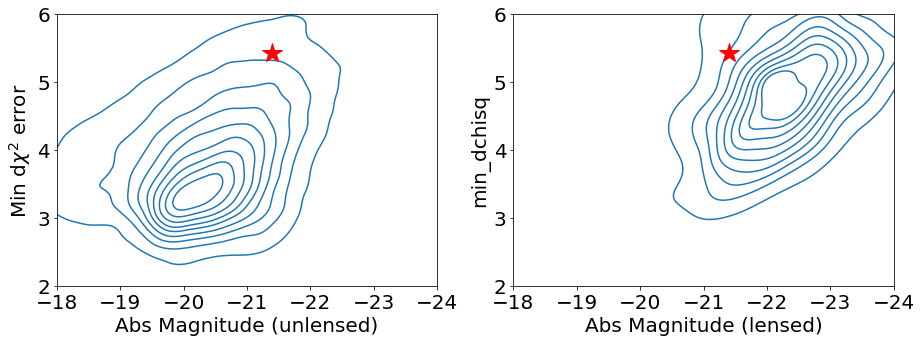

In [18]:
# Make contour plot of dchisq vs. abs magnitude
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.kdeplot(data1['abs_mag_r'], y=np.log10(data1['min_dchisq']), ax=axes[0])
axes[0].plot(Miptf, np.log10(dchisq_iptf), 'r*', ms=20)
axes[0].set_xlim([-18, -24])
axes[0].set_ylim([2, 6])
axes[0].set_xlabel("Abs Magnitude (unlensed)")
axes[0].set_ylabel("Min d$\chi^2$ error")

sns.kdeplot(data2['abs_mag_r'], y=np.log10(data2['min_dchisq']), ax=axes[1])
axes[1].plot(Miptf, np.log10(dchisq_iptf), 'r*', ms=20)
axes[1].set_xlim([-18, -24])
axes[1].set_ylim([2, 6])
axes[1].set_xlabel("Abs Magnitude (lensed)")

Text(0, 0.5, 'Log$_10$(r$\\chi^2$ error)')

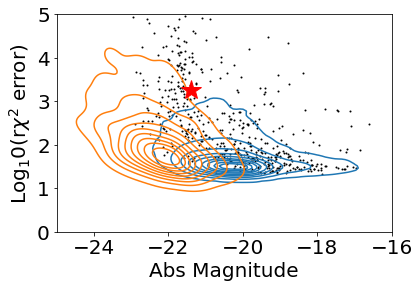

In [20]:
# Make contour plot of rchisq vs. abs magnitude
# fig, ax = plt.subplots()

chisq2 = np.array(data2[rchisq_labels])
sum_chisq2 = np.sum(chisq2, axis=1)

chisq1 = np.array(data1[rchisq_labels])
sum_chisq1 = np.sum(chisq1, axis=1)

chisq3 = np.array(data3[rchisq_labels])
sum_chisq3 = np.sum(chisq3, axis=1)

sns.kdeplot(data1['abs_mag_r'], y=np.log(data1['sum_rchisq']))
sns.kdeplot(data2['abs_mag_r'], y=np.log(data2['sum_rchisq']))

# IPTF16geu
plt.plot(Miptf, np.log(rchisq_iptf), 'r*', ms=20)
# Ampel run
plt.scatter(data3['abs_mag_r'], np.log(data3['sum_rchisq']), c='k', s=1)
# plt.plot([-20, -20], [-2,5], 'k--')
# plt.plot([-25, -16], [.5, .5], 'k--')

# Plotting
plt.xlim([-25, -16])
plt.ylim([0, 5])
plt.xlabel("Abs Magnitude")
plt.ylabel("Log$_10$(r$\chi^2$ error)")
# plt.legend()
# plt.savefig("rchisq_contours.png")

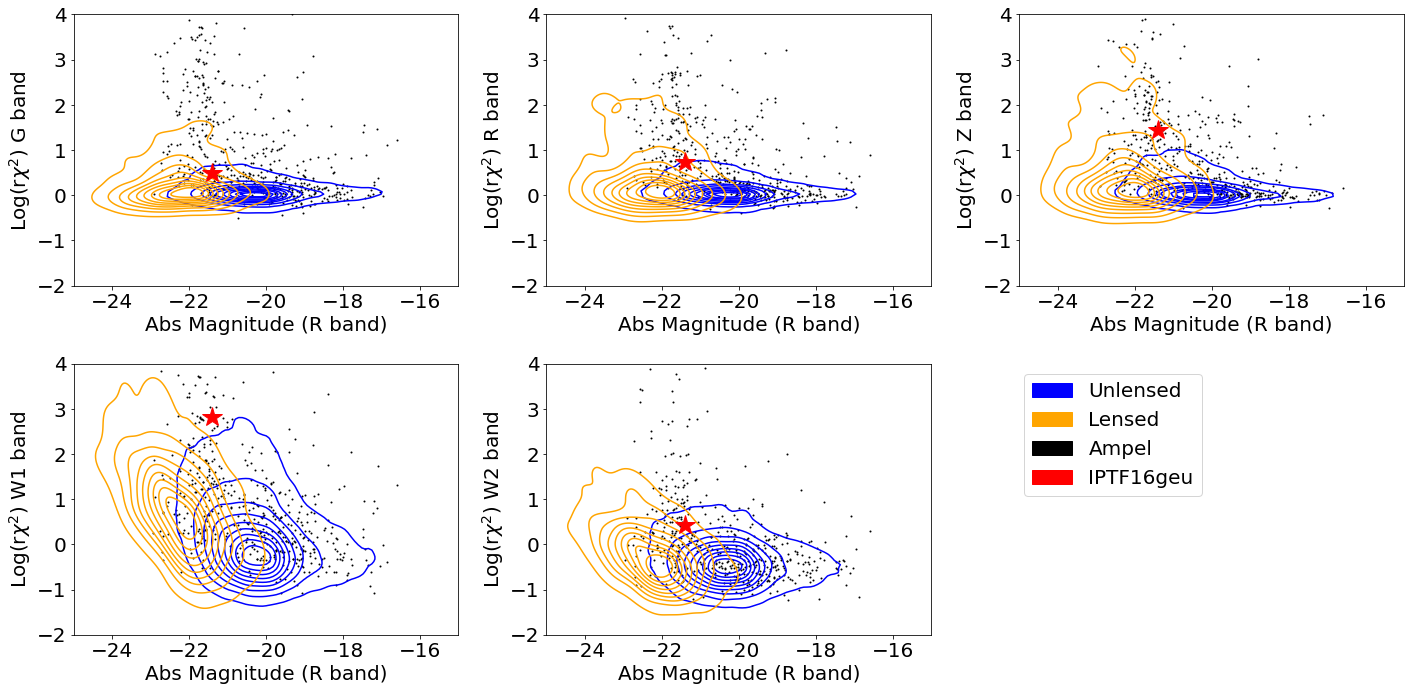

In [37]:
fig, axes = plt.subplots(2, 3, figsize=[20,10])
labels = ['g', 'r', 'z', 'w1', 'w2']

axes_flat = axes.flatten()[:-1]
for i, ax in enumerate(axes_flat):
    label = 'rchisq_'+labels[i]
    sns.kdeplot(data1['abs_mag_r'], y=np.log(data1[label]), color='b', ax=ax)
    sns.kdeplot(data2['abs_mag_r'], y=np.log(data2[label]), color='orange', ax=ax)
    ax.scatter(data3['abs_mag_r'], np.log(data3[label]), c='k', s=1)
    ax.plot(Miptf, np.log(iptf16[label]), 'r*', ms=20)
    
    # Labels
    ax.set_xlabel("Abs Magnitude (R band)")
    ax.set_ylabel(f"Log(r$\chi^2$) {labels[i].upper()} band")
    
    ax.set_xlim([-25, -15])
    ax.set_ylim([-2, 4])

# Legend
labels = ['Unlensed', 'Lensed', 'Ampel', 'IPTF16geu']
colors = ['b', 'orange', 'k', 'r']
handles = [mpl.patches.Patch(color=col, label=lab) for col, lab in zip(colors, labels)]
plt.legend(handles=handles, bbox_to_anchor=(.5, 1))

# axes[1,1].legend()
axes[1,2].axis('off')
plt.tight_layout()
plt.savefig("rchisq_bands.png", bbox_inches='tight')

In [10]:
data1.columns

Index(['ls_id', 'ra', 'dec', 'type', 'dered_mag_g', 'dered_mag_r',
       'dered_mag_z', 'dered_mag_w1', 'dered_mag_w2', 'snr_g', 'snr_r',
       'snr_z', 'snr_w1', 'snr_w2', 'z_phot_median', 'z_phot_std', 'z_spec',
       'dered_flux_g', 'dered_flux_r', 'dered_flux_z', 'dered_flux_w1',
       'dered_flux_w2', 'dchisq_1', 'dchisq_2', 'dchisq_3', 'dchisq_4',
       'dchisq_5', 'rchisq_g', 'rchisq_r', 'rchisq_z', 'rchisq_w1',
       'rchisq_w2', 'psfsize_g', 'psfsize_r', 'psfsize_z', 'sersic',
       'sersic_ivar', 'shape_e1', 'shape_e1_ivar', 'shape_e2', 'shape_e2_ivar',
       'shape_r', 'shape_r_ivar', 'lensed'],
      dtype='object')

In [12]:
data2['type'].value_counts()

SER    509
DEV    237
REX    122
EXP     14
Name: type, dtype: int64

In [13]:
data1['type'].value_counts()

REX    3910
EXP    2724
SER    1740
DEV    1626
Name: type, dtype: int64

In [21]:
bands = ['g', 'r', 'z', 'w1', 'w2']
trac_cols = ['ls_id', 'ra', 'dec', 'type'] \
            + ['dered_mag_'+b for b in bands] \
            + ['dered_flux_'+b for b in bands] \
            + ['snr_'+b for b in bands] \
            + ['flux_ivar_'+b for b in bands] \
            + ['dchisq_'+str(i) for i in range(1,6)] \
            + ['rchisq_'+b for b in bands] \
            + ['sersic', 'sersic_ivar'] \
            + ['psfsize_g', 'psfsize_r', 'psfsize_z'] \
            + ['shape_r', 'shape_e1', 'shape_e2'] \
            + ['shape_r_ivar', 'shape_e1_ivar', 'shape_e2_ivar']
phot_z_cols = ['z_phot_median', 'z_phot_std', 'z_spec']

query_cols = ','.join(['trac.'+col for col in trac_cols])+','+','.join(['phot_z.'+col for col in phot_z_cols])

In [24]:
query =["""SELECT """ + query_cols + """ FROM ls_dr9.tractor AS trac 
    INNER JOIN ls_dr9.photo_z AS phot_z ON trac.ls_id = phot_z.ls_id 
    WHERE (q3c_radial_query(ra,dec,{},{},{})) """,
    """ ORDER BY q3c_dist({}, {}, trac.ra, trac.dec) ASC""",
    """ LIMIT {}"""]
print(query)
len(query)

['SELECT trac.ls_id,trac.ra,trac.dec,trac.type,trac.dered_mag_g,trac.dered_mag_r,trac.dered_mag_z,trac.dered_mag_w1,trac.dered_mag_w2,trac.dered_flux_g,trac.dered_flux_r,trac.dered_flux_z,trac.dered_flux_w1,trac.dered_flux_w2,trac.snr_g,trac.snr_r,trac.snr_z,trac.snr_w1,trac.snr_w2,trac.flux_ivar_g,trac.flux_ivar_r,trac.flux_ivar_z,trac.flux_ivar_w1,trac.flux_ivar_w2,trac.dchisq_1,trac.dchisq_2,trac.dchisq_3,trac.dchisq_4,trac.dchisq_5,trac.rchisq_g,trac.rchisq_r,trac.rchisq_z,trac.rchisq_w1,trac.rchisq_w2,trac.sersic,trac.sersic_ivar,trac.psfsize_g,trac.psfsize_r,trac.psfsize_z,trac.shape_r,trac.shape_e1,trac.shape_e2,trac.shape_r_ivar,trac.shape_e1_ivar,trac.shape_e2_ivar,phot_z.z_phot_median,phot_z.z_phot_std,phot_z.z_spec FROM ls_dr9.tractor AS trac \n    INNER JOIN ls_dr9.photo_z AS phot_z ON trac.ls_id = phot_z.ls_id \n    WHERE (q3c_radial_query(ra,dec,{},{},{})) ', ' ORDER BY q3c_dist({}, {}, trac.ra, trac.dec) ASC', ' LIMIT {}']


3

# Augment data

In [85]:
from util import collect_gals, filter_data
import pandas as pd
import numpy as np

seed = 42

In [80]:
# Read in A lens IDs and write grade
A_lenses = pd.concat([pd.read_csv("../data/lensed/Huang21_A/dr9_sample.csv"), 
            pd.read_csv("../data/lensed/ML_A/dr9_sample.csv")])
A_lenses = filter_data(A_lenses)
A_lenses['grade'] = 'A'
A_lenses['weight'] = .7 / len(A_lenses)

# Read in B lens IDs and write grade
B_lenses = pd.concat([pd.read_csv("../data/lensed/Huang21_B/dr9_sample.csv"),
           pd.read_csv("../data/lensed/ML_B/dr9_sample.csv")])
B_lenses = filter_data(B_lenses)
B_lenses['grade'] = 'B'
B_lenses['weight'] = .2 / len(B_lenses)

# Read in C lens IDs and write grade
C_lenses = pd.concat([pd.read_csv("../data/lensed/Huang21_C/dr9_sample.csv"),
           pd.read_csv("../data/lensed/ML_C/dr9_sample.csv")])
C_lenses = filter_data(C_lenses)
C_lenses['grade'] = 'C'
C_lenses['weight'] = .1 / len(C_lenses)

# Read in full lens file
lenses = pd.concat([A_lenses, B_lenses, C_lenses])

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [81]:
import matplotlib.pyplot as plt

In [82]:
# Get a random sample of galaxies to duplicate/vary
augmented = lenses.sample(n=10000-len(lenses), replace=True, weights=lenses['weight'],
                          ignore_index=True, random_state=seed)

In [83]:
augmented['grade'].value_counts()/len(augmented)

A    0.710324
B    0.192330
C    0.097345
Name: grade, dtype: float64

In [60]:
# Vary by uncertainty
bands = ['g', 'r', 'z', 'w1', 'w2']
for b in bands:
    new_fluxes = np.random.normal(loc=augmented['dered_flux_'+b], scale=augmented['flux_sigma_'+b])
    augmented['dered_flux_'+b] = new_fluxes

A    0.476460
C    0.338997
B    0.184543
Name: grade, dtype: float64

In [56]:
band = 'g'
A_lenses[['unc_'+band, 'snr_'+band, 'flux_sigma_'+band, 'dered_flux_'+band, 'dered_mag_'+band]]

,unc_g,snr_g,flux_sigma_g,dered_flux_g,dered_mag_g
2,0.018051,55.397213,0.185410,11.078327,19.888815
3,0.007928,126.132780,0.041261,5.447954,20.659416
5,0.059343,16.851316,0.082473,1.483834,22.071537
7,0.017266,57.916718,0.065506,3.899020,21.022612
8,0.015313,65.302666,0.059430,4.603891,20.842188
...,...,...,...,...,...
242,0.002194,455.862730,0.090289,45.821457,18.347328
243,0.034104,29.321722,0.067225,2.022818,21.735107
245,0.004481,223.167790,0.168151,39.073290,18.520300
246,0.004778,209.288020,0.118627,27.920706,18.885183


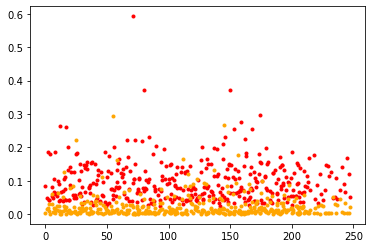

In [58]:
plt.plot(A_lenses['flux_sigma_'+band], 'r.')
plt.plot(A_lenses['unc_'+band], '.', color='orange')
# plt.plot(A_lenses['dered_flux_'+band], 'b.')
# plt.plot(A_lenses['dered_mag_'+band], 'g.')

# Machine Learning

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
# from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [2]:
lens_file = "../data/dr9_training/dr9_lensed.csv"
unlens_file = "../data/dr9_training/dr9_unlensed.csv"
bands = ['g', 'r', 'z', 'w1', 'w2']
use_cols = ['g-r', 'r-z', 'r-w1', 'r-w2', 'abs_mag_r', 'z_phot_median']
use_cols.extend([f"rchisq_{band}" for band in bands])
seed = 42

##### Load in data

In [3]:
lensed = pd.read_csv(lens_file)
unlensed = pd.read_csv(unlens_file)

all_data = pd.concat([lensed, unlensed])
all_data = all_data.sample(frac=1, random_state=seed).reset_index(drop=True)
all_data

,ls_id,ra,dec,type,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,snr_g,...,shape_r,shape_r_ivar,lensed,g-r,r-z,r-w1,r-w2,min_dchisq,sum_rchisq,abs_mag_r
0,9906618041304647,36.702335,-9.072599,DEV,20.586185,18.772620,17.794395,17.107239,17.678164,0.009204,...,0.096509,161259.3000,True,1.813565,0.978225,1.665381,1.094456,282735.5600,8.238123,-22.657984
1,9906620511555753,145.227631,-2.400903,SER,20.427235,19.823359,19.211897,19.159266,19.042194,151.428330,...,0.780352,66684.5700,False,0.603876,0.611462,0.664093,0.781165,63970.6500,8.390236,-20.611317
2,9906621172092081,144.919649,-0.859355,DEV,21.300589,19.956882,19.242168,19.329815,19.844929,63.673046,...,0.764162,16657.3870,False,1.343707,0.714714,0.627067,0.111953,40629.4700,4.993243,-20.342952
3,9906619946239506,146.770490,-4.060936,EXP,22.366137,21.497026,21.168858,22.298111,23.456766,19.973860,...,1.193695,2650.5050,False,0.869111,0.328168,-0.801085,-1.959740,983.1138,4.614417,-19.830559
4,9906620228571640,145.408511,-3.279308,EXP,21.455177,19.967554,19.040688,18.299610,18.624481,42.018646,...,1.388494,7609.5063,False,1.487623,0.926866,1.667944,1.343073,11415.6130,4.461830,-21.243914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10851,9906621360900762,145.110552,-0.186350,EXP,23.137894,21.974014,20.968134,19.591158,20.276485,20.472271,...,0.595212,2795.1428,False,1.163880,1.005880,2.382856,1.697529,2935.3240,3.878718,-20.321394
10852,9906620605731574,144.479630,-2.275769,SER,20.093344,19.314642,18.777859,18.716175,18.717258,114.795630,...,1.374201,22882.9410,False,0.778702,0.536783,0.598467,0.597384,30471.6800,5.798239,-21.016466
10853,9906620889108691,145.459736,-1.458902,EXP,22.047142,21.347395,20.900858,21.042910,24.073977,32.867004,...,1.220667,1377.7731,False,0.699747,0.446537,0.304485,-2.726582,2664.1162,4.482348,-19.787837
10854,9906620606583503,147.727208,-2.339327,DEV,23.320286,21.508337,20.402565,19.466980,20.811956,12.693677,...,0.589488,1689.5154,False,1.811949,1.105772,2.041357,0.696381,4241.4385,4.119154,-20.169023


##### Split into training and testing sets

In [4]:
X, y = all_data[use_cols], all_data['lensed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed)

In [5]:
parameters = {
    'n_estimators': np.arange(50, 550, 50),
    'max_depth': np.arange(3, 21, 2),
    'max_samples': np.arange(0.7, 1.1, .1),
    'criterion': ('gini', 'entropy'),
    'max_features': ('auto', None),
    'random_state': [seed],
    'class_weight': ['balanced'],
}

In [6]:
# Random Forest model
# model = RandomForestClassifier(n_estimators=200, max_depth=5, max_samples=.8, 
#                              class_weight='balanced', random_state=seed)
# define evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
# # evaluate model
# # scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

# rf = RandomForestClassifier()
# # Grid search
# clf = GridSearchCV(rf, parameters, scoring='roc_auc', cv=cv)
# clf.fit(X_train, y_train)

In [7]:
# # Predict
# y_pr = clf.decision_function(X_test)
# preds = clf.predict(X_test)
# # summarize performance
# print('ROC AUC: %.3f' % roc_auc_score(y_test, y_pr))
# # print('Std Dev: %.3f' % np.std(scores))
# print("Confusion matrix:")
# confusion_matrix(y_test, preds)

##### Classify

In [8]:
clf = RandomForestClassifier(n_estimators=200, max_depth=5, max_samples=.8, 
                             class_weight='balanced', random_state=seed)

In [9]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_samples=0.8,
                       n_estimators=200, random_state=42)

In [10]:
preds = clf.predict(X_test)
accuracy_score(y_test, preds)

0.929097605893186

In [11]:
confusion_matrix(y_test, preds)

array([[1863,  142],
       [  12,  155]])

In [12]:
pd.DataFrame(clf.feature_importances_.reshape(1, -1), columns=X_train.columns)

,g-r,r-z,r-w1,r-w2,abs_mag_r,z_phot_median,rchisq_g,rchisq_r,rchisq_z,rchisq_w1,rchisq_w2
0,0.08734,0.129792,0.046107,0.022698,0.546245,0.015207,0.017269,0.020466,0.035694,0.070966,0.008216


### Ampel data classified

In [13]:
ampel_data = pd.read_csv("../data/dr9_training/ampel_test.csv")
test_data = ampel_data[use_cols]
ampel_data['lensed'] = clf.predict(test_data)

In [14]:
lens_cands = ampel_data[ampel_data['lensed']]
lens_cands = lens_cands[['ls_id', 'ra', 'dec']]
# lens_cands.to_csv("../data/dr9_training/ampel_candidates.csv", index=False)
lens_cands

,ls_id,ra,dec
0,9906626190446675,339.504678,12.590152
9,9906620181841745,326.766587,-3.539431
11,9906616821878617,346.364311,-12.582950
17,9906631083100135,355.347056,26.334676
19,9906617280889281,333.032626,-11.301574
...,...,...,...
452,9906616179362060,350.811290,-14.307182
458,9906624927501582,117.573499,9.231810
460,9906629182098217,10.306205,20.994368
475,9906616463789078,26.756593,-13.146844


### COSMOS data classified

In [15]:
cosmos_data = pd.read_csv("../data/dr9_training/dr9_cosmos_test.csv")
test_data = cosmos_data[use_cols]
cosmos_data['lensed'] = clf.predict(test_data)

In [16]:
lens_cands = cosmos_data[cosmos_data['lensed']]
lens_cands = lens_cands[['ls_id', 'ra', 'dec']]
# lens_cands.to_csv("../data/dr9_training/cosmos_candidates.csv", index=False)
lens_cands

,ls_id,ra,dec
14,9906620322810779,145.155979,-3.040837
22,9906620322811323,145.186169,-3.044539
25,9906620322809976,145.110965,-2.987331
35,9906620322809844,145.103526,-2.965712
52,9906620322811018,145.170480,-2.969162
...,...,...,...
80635,9906620606514540,147.323681,-2.238612
80638,9906620606515154,147.348849,-2.252301
80667,9906620795129671,146.969505,-1.642987
80690,9906620606451361,147.226845,-2.152765


### Test data classified

In [22]:
one_gal = pd.read_csv('../data/special_run/galaxy_info.csv')
one_gal = one_gal[use_cols]
clf.predict(one_gal)

array([False])

# Ampel run

In [1]:
from util import collect_gals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

In [2]:
data = collect_gals("../data/ampel_run")
data = data[data['z_phot_median']>=0]
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [3]:
data

,ls_id,ra,dec,type,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,snr_g,...,psfsize_r,psfsize_z,sersic,sersic_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,shape_r,shape_r_ivar
0,9906626190446675,339.504678,12.590152,SER,17.274237,16.327522,15.667729,15.858350,16.365630,0.002002,...,9197.47950,1.364956,2.119449,1.116753,4.160773,89431.600,0.017794,700729.940,0.034764,998456.560
1,9906628295266353,24.446324,18.377803,SER,18.438350,17.664242,17.085630,16.392185,16.196589,0.001971,...,4216.94780,1.779299,1.421529,1.647529,1.038640,334908.280,-0.044761,350040.720,0.091164,554638.200
2,9907732793330661,279.468548,32.884967,REX,20.619589,19.768860,19.233198,19.248898,19.860447,0.009714,...,0.00000,2.131331,2.433292,1.163009,0.379507,28700.676,0.000000,0.000,0.000000,0.000
3,9906620618904648,194.687165,-2.287789,SER,18.974031,18.300507,17.691603,16.728569,16.642950,0.002433,...,142.61302,1.574747,1.529170,1.322073,0.725395,106753.530,-0.066110,66314.690,0.088478,85134.984
4,9907736021568351,162.932965,44.122499,REX,20.470890,20.285822,20.214720,20.296675,20.797098,0.009371,...,0.00000,2.388395,1.671395,1.372762,0.455471,12305.658,0.000000,0.000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,9906628745692582,38.513121,19.778986,SER,20.615206,20.119373,19.788725,20.356400,20.884573,0.012112,...,878.79870,1.991021,1.357979,1.572777,1.299122,49949.650,-0.255090,52010.130,-0.171301,51851.184
863,9906616186176377,17.537106,-14.037272,PSF,20.136340,20.183264,19.470478,18.319128,18.013546,0.003702,...,0.00000,1.172151,1.020484,1.174903,0.000000,0.000,0.000000,0.000,0.000000,0.000
864,9906618304630170,332.107606,-8.524351,EXP,20.576668,20.255249,20.069975,20.331870,21.617674,0.007245,...,0.00000,1.802944,1.427711,1.347097,1.059744,16313.130,0.143608,14957.955,-0.205817,18269.914
866,9906619995653644,335.547332,-4.006682,SER,17.087030,16.223003,15.647518,15.981176,16.495977,0.001417,...,10651.08700,1.799602,1.517788,1.115061,4.348343,1158340.600,0.015084,1659860.200,0.157347,2303901.000


In [4]:
data.to_csv("../data/ampel_run/galaxy_info.csv", index=False)

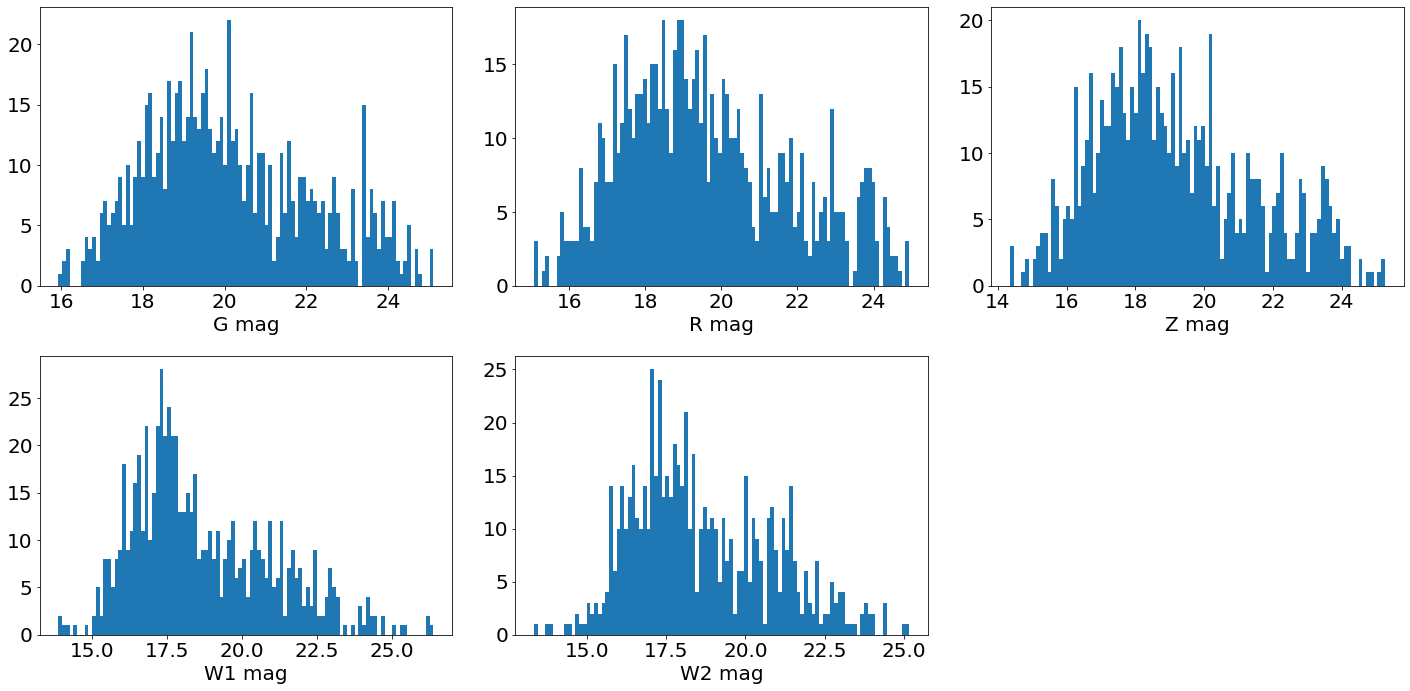

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))

axes[0,0].hist(data['dered_mag_g'], bins=100)
axes[0,0].set_xlabel('G mag')

axes[0,1].hist(data['dered_mag_r'], bins=100)
axes[0,1].set_xlabel('R mag')

axes[0,2].hist(data['dered_mag_z'], bins=100)
axes[0,2].set_xlabel('Z mag')

axes[1,0].hist(data['dered_mag_w1'], bins=100)
axes[1,0].set_xlabel('W1 mag')

axes[1,1].hist(data['dered_mag_w2'], bins=100)
axes[1,1].set_xlabel('W2 mag')

axes[1,2].axis('off')
plt.tight_layout()
plt.savefig('ampel_magnitudes.png', bbox_inches='tight')

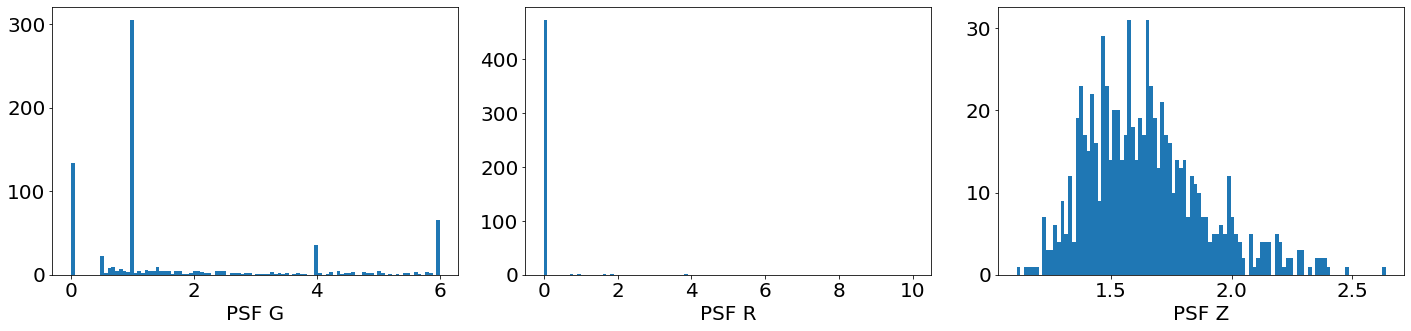

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

axes[0].hist(data['psfsize_g'], bins=100)
axes[0].set_xlabel('PSF G')

axes[1].hist(data['psfsize_r'], bins=100, range=(0,10))
axes[1].set_xlabel('PSF R')

axes[2].hist(data['psfsize_z'], bins=100)
axes[2].set_xlabel('PSF Z')

plt.tight_layout()
plt.savefig("ampel_psfs.png", bbox_inches='tight')

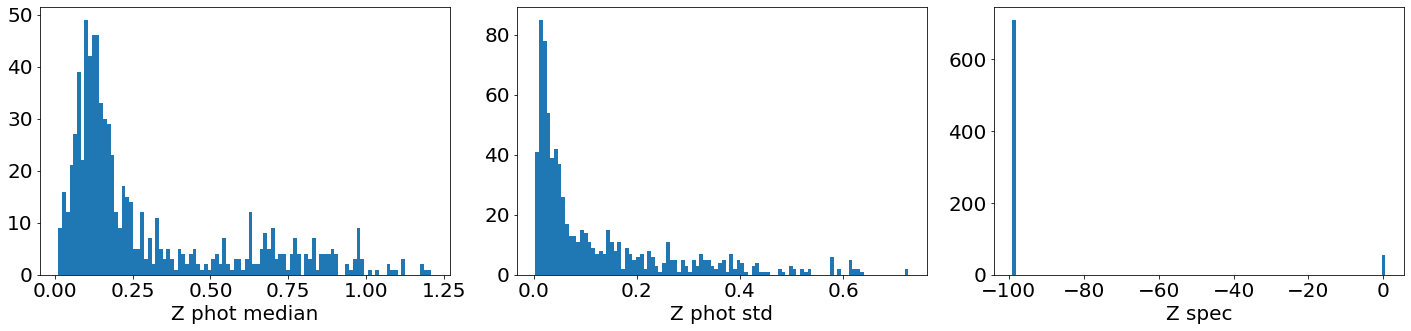

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

axes[0].hist(data['z_phot_median'], bins=100)
axes[0].set_xlabel('Z phot median')

axes[1].hist(data['z_phot_std'], bins=100)
axes[1].set_xlabel('Z phot std')

axes[2].hist(data['z_spec'], bins=100)
axes[2].set_xlabel('Z spec')

plt.tight_layout()
plt.savefig("ampel_phot.png", bbox_inches='tight')
# reject anything that has a value less than zero

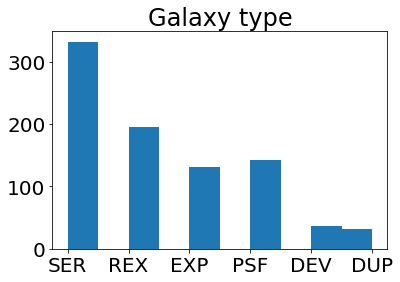

In [61]:
plt.hist(data['type'])
plt.title("Galaxy type")
plt.savefig("ampel_types.png", bbox_inches='tight')

# Results of grid search

In [19]:
import pickle

In [23]:
with open('gridsearch_model.sav', 'rb') as file:
    clf = pickle.load(file)

In [24]:
preds = clf.predict(X_test)
print(accuracy_score(y_test, preds))
confusion_matrix(y_test, preds)

0.9654696132596685


array([[1969,   36],
       [  39,  128]])

In [25]:
clf.predict(one_gal)

array([False])